In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import IPython.display
import pygame

NOTEBOOK_ID = "COLLISION_BASIS"
OUTPUT_PATH = f"out/{NOTEBOOK_ID}/"

if not os.path.isdir(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

plt.rcParams['font.family'] = ["D2Coding"]
pygame.init()


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


(6, 0)

# 점과 물체의 충돌 판별

어떤 점 $P(x,y)$가 물체와 충돌을 한다고 하면 최소한 그 물체 내부 혹은 그 경계에 있다는 것이다.

## 점과 원의 충돌 판별

점 $P$가 임의의 중심을 $C(C_x, C_y)$으로 하고 반지름을 $r$로 하는 원 $O$와 충돌한다고 하면 다음이 성립해야 한다.

> $$\overline{PC} \leq r$$

이는 점과 점 사이의 거리 공식에 따라 다음과 같이 쓸 수 있다.

> $$(C_x-x)^2+(C_y-y)^2 \leq r^2$$

## 점과 변이 축과 평행한 사각형의 충돌 판별

점 $P$가 각 꼭짓점이 $(x_1, y_1),\,(x_2, y_1),\,(x_1,y_2),\,(x_2,y_2)\quad(x_1 < x_2, \,y_1 < y_2)$인 사각형과 충돌한다고 하면 다음이 성립해야 한다.

> $$x_1\leq x\leq x_2\quad \text{and}\quad y_1 \leq y \leq y_2$$

## 점과 삼각형의 충돌

점 $P$가 각 꼭짓점이 $A(x_1, y_1),\,B(x_2, y_2),\,C(x_3,y_3)$인 삼각형 $\triangle{ABC}$ 내부에 존재한다고 하면 다음이 성립한다.

> $$V_0 = \vec{AP}\times\vec{AB},\,V_1=\vec{BP}\times\vec{BC},V_2=\vec{CP}\times\vec{CA}$$
> $$V_0, V_1, V_2 \leq 0\quad \text{or} \quad V_0, V_1, V_2 \geq 0$$

다만 외적을 이용하여 다른 방법에 비해 상대적으로 느리다.

In [2]:
def collide_point_with_circle(point, center, radius):
    return (center[0] - point[0]) ** 2 + (center[1] - point[1]) ** 2 <= radius ** 2


def collide_point_with_rect(point, rect): # rect(x1, x2, y1, y2)
    return rect[0] <= point[0] <= rect[1] and rect[2] <= point[1] <= rect[3]


def collide_point_with_triangle(point, A, B, C):
    V0, V1, V2 = np.cross(point - A, B - A), np.cross(point - B, C - B), np.cross(point - C, A - C)
    return (V0 >= 0 and V1 >= 0 and V2 >= 0) or (V0 <= 0 and V1 <= 0 and V2 <= 0)

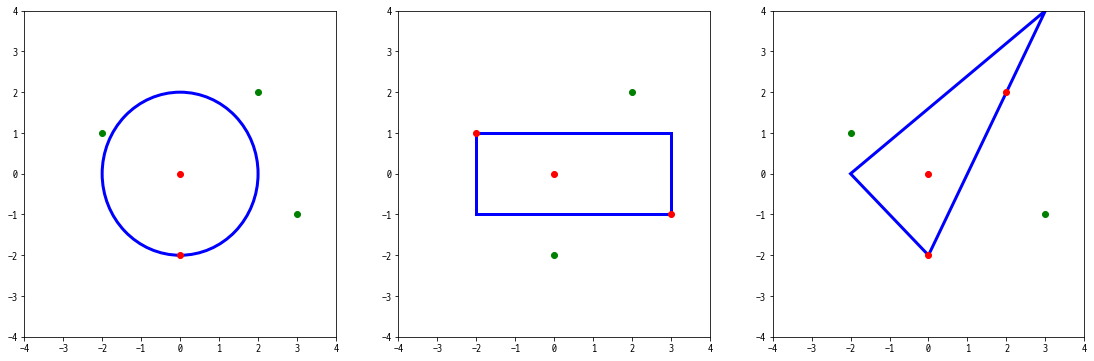

In [3]:
Ps = [np.array((0, 0)), np.array((2, 2)), np.array((-2, 1)), np.array((3, -1)), np.array((0, -2))]

circle = (np.array((0, 0)), np.sqrt(4))
rect = np.array((-2, 3, -1, 1))
triangle = (np.array((-2, 0)), np.array((0, -2)), np.array((3, 4)))

fig, ax = plt.subplots(1, 3,figsize=(19, 6))

for i in range(3):
    ax[i].set_xlim((-4, 4))
    ax[i].set_ylim((-4, 4))

ax[0].add_patch(patches.Circle(*circle, linewidth=3, fill=False, color='blue'))
ax[1].add_patch(patches.Rectangle((rect[0], rect[2]), rect[1] - rect[0], rect[3] - rect[2], fill=False, linewidth=3, color='blue'))
ax[2].add_patch(patches.Polygon(triangle, fill=False, linewidth=3, color='blue'))

for p in Ps:
    if collide_point_with_circle(p, *circle):
        ax[0].plot([p[0]], [p[1]], 'o', color='red')
    else:
        ax[0].plot([p[0]], [p[1]], 'o', color='green')

for p in Ps:
    if collide_point_with_rect(p, rect):
        ax[1].plot([p[0]], [p[1]], 'o', color='red')
    else:
        ax[1].plot([p[0]], [p[1]], 'o', color='green')

for p in Ps:
    if collide_point_with_triangle(p, *triangle):
        ax[2].plot([p[0]], [p[1]], 'o', color='red')
    else:
        ax[2].plot([p[0]], [p[1]], 'o', color='green')

plt.show()

## 점과 볼록 다각형의 충돌

위에 있는 점과 삼각형의 충돌을 이용할 것이다.

볼록 다각형은 대부분 삼각형으로 분해할 수 있으니 (오목 다각형에 대해서는 잘 모르겠다)

$n$각형 $A$의 점들을 점 $A_1$을 기준으로 시계 반대 방향으로 $A_1, A_2, A_3, \cdots, A_n$이라고 하자.

이때 다각형 $A$는 $\triangle{A_1A_2A_3}, \triangle{A_1A_3A_4}, \cdots, \triangle{A_1A_{n-1}A_n}$로 겹치는 구간 없이 분할될 수 있다. 이때 점 $P$가 이 모든 삼각형 안에 하나라도 존재한다면 $P$는 다각형 안에 존재하게 된다.

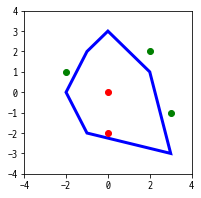

In [4]:
def collide_point_with_polygon(point, poly):
    pivot = poly[0]
    return any([collide_point_with_triangle(point, pivot, a, b) for a, b in zip(poly[1:-1], poly[2:])])

Ps = [np.array((0, 0)), np.array((2, 2)), np.array((-2, 1)), np.array((3, -1)), np.array((0, -2))]
A = [np.array((0, 3)), np.array((-1, 2)), np.array((-2, 0)), np.array((-1, -2)), np.array((3, -3)), np.array((2, 1))] # Polygon

fig, ax = plt.subplots(figsize=(3, 3))

ax.set_xlim((-4, 4))
ax.set_ylim((-4, 4))

ax.add_patch(patches.Polygon(A, fill=False, linewidth=3, color='blue'))

for p in Ps:
    if collide_point_with_polygon(p, A):
        ax.plot([p[0]], [p[1]], 'o', color='red')
    else:
        ax.plot([p[0]], [p[1]], 'o', color='green')

plt.show()